In [1]:
import sys

sys.path.append("../")


from rdkit import Chem
from rdkit.Chem import Draw
from sqlmodel import create_engine, Session, select
from chemicalite_orm.models import Compound
from chemicalite_orm.molecules import SMILES_SAMPLE as mols
from sqlalchemy import event
from chemicalite_orm.types import mol_from_smiles
from chemicalite_orm.functions import mol_is_substruct

In [2]:
DATABASE_URL = "sqlite:///chemicalite.db"

engine = create_engine(DATABASE_URL, echo=True)


@event.listens_for(engine, "connect")
def load_chemicalite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("chemicalite")


Compound.__table__.create(engine)

2025-04-26 12:14:11,802 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-26 12:14:11,804 INFO sqlalchemy.engine.Engine 
CREATE TABLE compound (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	smiles VARCHAR NOT NULL, 
	molecule mol NOT NULL, 
	PRIMARY KEY (id)
)


2025-04-26 12:14:11,804 INFO sqlalchemy.engine.Engine [no key 0.00074s] ()
2025-04-26 12:14:11,809 INFO sqlalchemy.engine.Engine 
        CREATE VIRTUAL TABLE IF NOT EXISTS str_idx_compound
        USING rdtree(id, fp bits(2048))
    
2025-04-26 12:14:11,810 INFO sqlalchemy.engine.Engine [generated in 0.00088s] ()
2025-04-26 12:14:11,818 INFO sqlalchemy.engine.Engine COMMIT


In [3]:
def insert_test_data():
    with Session(engine) as session:
        for i, smiles in enumerate(mols):
            compound = Compound(
                name=f"mol_{i}",
                smiles=smiles,
                molecule=smiles,
            )
            session.add(compound)
        session.commit()


insert_test_data()

2025-04-26 12:14:14,399 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-26 12:14:14,402 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_smiles(?))
2025-04-26 12:14:14,402 INFO sqlalchemy.engine.Engine [generated in 0.00085s] ('mol_0', 'NN=C(c1ccccc1)c1ccccc1', 'NN=C(c1ccccc1)c1ccccc1')
2025-04-26 12:14:14,411 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_smiles(?))
2025-04-26 12:14:14,411 INFO sqlalchemy.engine.Engine [cached since 0.009738s ago] ('mol_1', 'COc1ccc(C=NO)cc1', 'COc1ccc(C=NO)cc1')
2025-04-26 12:14:14,412 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_smiles(?))
2025-04-26 12:14:14,413 INFO sqlalchemy.engine.Engine [cached since 0.0115s ago] ('mol_2', 'c1ccc(C(=NC(c2ccccc2)c2ccccc2)c2ccccc2)cc1', 'c1ccc(C(=NC(c2ccccc2)c2ccccc2)c2ccccc2)cc1')
2025-04-26 12:14:14,414 INFO sqlalchemy.engine.Engine INSERT INTO compo

In [4]:
def test_substructure(smarts="c1ccccc1"):
    smis = []

    query_mol = mol_from_smiles(smarts)
    with Session(engine) as session:
        results = session.exec(
            select(Compound).where(mol_is_substruct(Compound.molecule, query_mol))
        ).all()

        for r in results:
            smis.append(r.smiles)
    return smis

smis = test_substructure()

2025-04-26 12:15:09,056 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-26 12:15:09,060 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE mol_is_substruct(compound.molecule, mol_from_smiles(?))
2025-04-26 12:15:09,061 INFO sqlalchemy.engine.Engine [no key 0.00099s] ('c1ccccc1',)
2025-04-26 12:15:09,066 INFO sqlalchemy.engine.Engine ROLLBACK


/home/hui/bin/miniforge3/envs/py39/lib/python3.9/site-packages/sqlmodel/orm/session.py:66: SAWarning: Class mol_is_substruct will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
  results = super().execute(


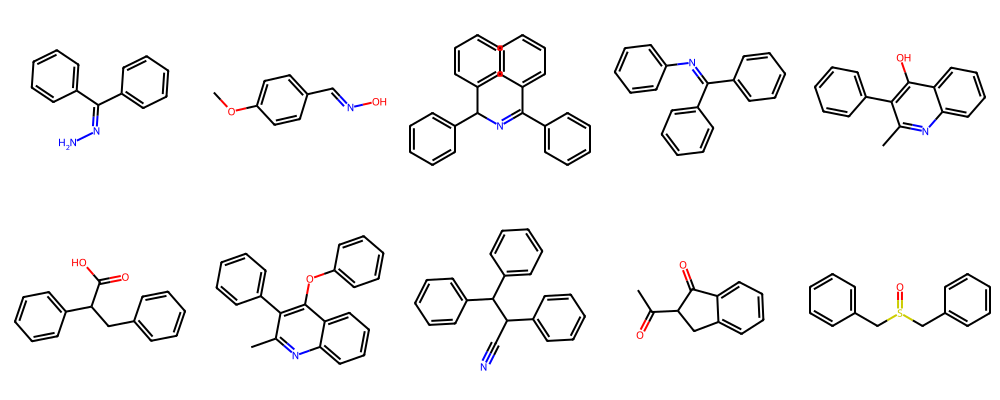

In [5]:
res_mols = [Chem.MolFromSmiles(smi) for smi in smis[:10]]
Draw.MolsToGridImage(res_mols, molsPerRow=5)